### Exploring Sample - Param Correlation with Linear Models 

In [1]:
# GOAL : Design a synthetic experiment where there is an explicit link between a weight partition and a data partition

Let's generate $N$ examples from $y = x^T\theta_A$ with $x \sim \mathcal{N}(0, I) \in \mathbb{R}^D$ and write the set $ \{ (x_1, y_1), ... (x_N, y_N) \} $ as a design matrix $A \in \mathbb{R}^{N x D}$

Let's do the same thing with a new vector $\theta_B$ (the reste being the same) and generate the set $B \in \mathbb{R}^{N x D}$

We want the output for each example to depend only on a subset of weights, and to be invariant to the rest. To mimic this, we can add random features to each matrix : 
$$
A := [A^T, N_a^T]^T\in \mathbb{R}^{N x 2D} \\
B := [N_b^T, B^T]^T \in \mathbb{R}^{N x 2D}
$$

if we concat both datasets we get $[A,B] \in \mathbb{R}^{2N x 2D}$. 

#### Q : can we use gradient information to cluster the parameters $\hat{\theta} \in \mathbb{R}^{2D}$ such that we get back the partition of A and B ?

In [1]:
import numpy as np
from sklearn.cluster import KMeans

In [865]:
# set constant values
N = 50000   # number of datapoints 
D = 8       # number of features

In [866]:
""" method to generate data """

def gen_dataset(mu_x=0, std_x=1, mu_ts_a=0, mu_ts_b=0):
    
    # scale = 1/mu_x if abs(mu_x) >= 1 else 1
    X  = np.random.normal(size=(2*N, 2*D), loc=mu_x) #, scale=scale)
    
    theta_A = np.random.normal(size=(D,), loc=mu_ts_a)
    theta_B = np.random.normal(size=(D,), loc=mu_ts_b)
    
    y1 = X[:N, :D].dot(theta_A)
    y2 = X[N:, D:].dot(theta_B)
    y  = np.concatenate((y1, y2))
    
    return {'X' : X, 'y': y, 'theta_A': theta_A, 'theta_B': theta_B}

In [867]:
""" methods related to Linear Regression """

def per_sample_gradient(X, y, theta):
    N, D = X.shape
    assert y.shape == (N,)
    assert theta.shape == (D,)
    
    # we want a num_samples x D matrix
    # for a single point (x [D x 1], y [1 x 1]) the gradient is prop. to (-y x  +   xT \theta x)
    # we tile this up and get the following eqn
    return -y.reshape(N, 1) * X + X.dot(theta.reshape(D, 1)) * X

def full_gradient(X, y, theta):
    N, D = X.shape
    assert y.shape == (N,)
    assert theta.shape == (D,)
    
    return -y.T.dot(X) + theta.T.dot(X.T).dot(X)

In [868]:
# make sure our gradient is ok 
for _ in range(5):
   
    # data 
    dataset = gen_dataset()
    
    theta_init = np.random.normal(size=(2 * D,))
    per_sample_grads = per_sample_gradient(dataset['X'], dataset['y'], theta_init)
    grads = full_gradient(dataset['X'], dataset['y'], theta_init)

    assert np.allclose(per_sample_grads.sum(0), grads)

### Let's compute some gradients :) 

We want to build a $2N \times 2D$ Matrix $M$ with M[i,j] corresponds to the gradient of the $j$-th features in the $i$-th example. We can then interpret each of the $2D$ rows as a features for each parameter. The next question is whether or not these features are useful enough to recover the original $A-B$ split should we cluster over these features. 

In [870]:
def trial(**kwargs): 
    
    # generate some data 
    dataset = gen_dataset(**kwargs)
    
    # init weights 
    theta_hat = np.random.normal(size=(2 * D,))
    
    # our 2N x 2D matrix
    M_grad = per_sample_gradient(dataset['X'], dataset['y'], theta_hat)
    
    # cluster labels
    # SCALE GRADS ?
    # M_grad = M_grad / np.abs(M_grad).max()
    
    km    = KMeans(n_clusters=2).fit(M_grad.T)
    label = km.labels_ # (2D,) vector
    clusters = km.cluster_centers_
    
    # Hacky way to compute cluster accuracy 
    label_A, label_B = int(label[:D].mean() + 0.5), int(label[D:].mean() + 0.5)
    
    if label_A == label_B : 
        acc = 0 
    else:
        acc = (np.sum(label[:D] == label_A) + np.sum(label[D:] == label_B)) / (2*D)
    
    return {'cluster_acc': acc, 'label': label, 'M_grad': M_grad, 'dataset': dataset, 'clusters': clusters}

## Reproducing the plots from Yesterday

Starting with zero-centered features

In [875]:
import matplotlib.pyplot as plt

def show(results, mu_x):
    # build a 2D matrix from the results
    mat = np.zeros((10, 10))

    for k, v in results.items():
        mu_a, mu_b = [int(x) for x in k.split('_')]
        mat[mu_a + 5, mu_b + 5] = v.mean()

    plt.imshow(mat, interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(10), labels=[str(x) for x in range(-5, 5)])
    plt.yticks(ticks=np.arange(10), labels=[str(x) for x in range(-5, 5)])
    plt.xlabel('mean theta A')
    plt.ylabel('mean theta B')
    plt.title(f'Cluster Accuracy. X ~ N({mu_x},1)')
    plt.show()

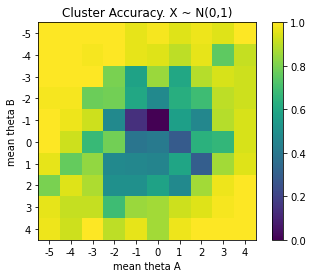

In [876]:
results_0 = {}
trials_per_cfg = 5

for mu_a in range(-5, 5):
    for mu_b in range(-5, 5):
        
        cfg = {'mu_ts_a' : mu_a, 'mu_ts_b' : mu_b, 'mu_x': 0}
        
        cluster_acc = []
        for _ in range(trials_per_cfg):
            cluster_acc += [trial(**cfg)['cluster_acc']]
        
        cluster_acc = np.array(cluster_acc)
        
        results_0[f'{mu_a}_{mu_b}'] = cluster_acc
        
show(results_0, mu_x=0)

##### Now trying with features centered around 3

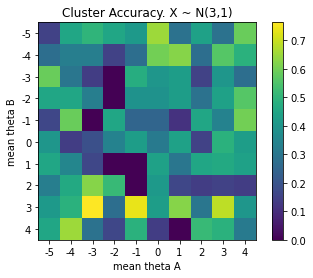

In [877]:
results_3 = {}
trials_per_cfg = 5

for mu_a in range(-5, 5):
    for mu_b in range(-5, 5):
        
        cfg = {'mu_ts_a' : mu_a, 'mu_ts_b' : mu_b, 'mu_x': 3}
        
        cluster_acc = []
        for _ in range(trials_per_cfg):
            cluster_acc += [trial(**cfg)['cluster_acc']]
        
        cluster_acc = np.array(cluster_acc)
        
        results_3[f'{mu_a}_{mu_b}'] = cluster_acc
        
show(results_3, mu_x=3)

## Discussion : 
Accuracy is much lower now that the features are generated differently. Let's investigate a bit; I want to know a) how easy the features are to cluster and b) how far off are the cluster means we got from k-means from the average gradient (over points). 

To do this, I will reshape our gradient matrix $M \in \mathbb{R}^{2N x 2D}$ in 4 $N x D$ matrices (so shape (2, 2, D)). Such that $M[0,0]$ and $M[1, 1]$ represent $A, \theta_a$ and $B, \theta_b$ respectively (i.e. the points with the features used to produce the label). We also have $M[0, 1]$ and $M[1, 0]$ which index $A, \theta_b$ and $B, \theta_a$ i.e points and their set of unused features

In [903]:
""" Helpers to look summarize some gradient info """

np.set_printoptions(precision=2)

def show_grad(M):
    # M : 2N x 2D grad matrix 
    
    # splits the grad in 4 regions, M[:N,:D] and M[N:,D:] whose features are used for the labels
    # and the other 2 regions whose features are the added noise
    
    grad = np.zeros((2, 2, D))
    grad[0, 0] = M[:N, :D].mean(0)
    grad[1, 1] = M[N:, D:].mean(0)
    
    grad[0, 1] = M[:N, D:].mean(0)
    grad[1, 0] = M[N:, :D].mean(0)
    
    # 1st col of grad (grad[:, 0]) --> features used in A
    # 2nd col of grad (grad[:, 1]) --> feautres used in B
    
    # 1st row (grad[0]) --> features for first N points
    # 2nd row (grad[1]) --> features for last N points
    # grad = (grad * 100).astype('int')
    size = len(str(grad[0, 0]))
    alinea = ' ' * (size // 2)
    
    print(f'{alinea}grad N_a theta_a{alinea}grad N_a theta_b')
    print(grad[0, 0], grad[0, 1])
    
    print(f'{alinea}grad N_b theta_a{alinea}grad N_b theta_b')
    print(grad[1, 0], grad[1, 1])
    
    print('\n with each theta_a/b averaged out over points N_a/N_b')
    print(grad.mean(2))
    # print('std')
    # print(grad.std(2))
    
    return grad

def show_clusters(cluster):
    # cluster : 2 x 2N
    size = cluster.shape[1] // 2
    cc = np.zeros((2, 2))
    cc[0,0] = cluster[0, :size].mean()
    cc[0,1] = cluster[0, size:].mean()
    cc[1,0] = cluster[1, :size].mean()
    cc[1,1] = cluster[1, size:].mean()  

    print(cc.T) 

### CASE 1 
Starting with a parameter combination we know works well

In [904]:
cfg = {'mu_ts_a' : 3, 'mu_ts_b' : 3, 'mu_x': 0}
out = trial(**cfg)

In [905]:
X, y, M = out['dataset']['X'], out['dataset']['y'], out['M_grad']

In [906]:
print('Accuracy : ', out['cluster_acc'])
_ = show_grad(M)

print('\nK-Means Clusters')
_ = show_clusters(out['clusters'])

Accuracy :  1.0
                        grad N_a theta_a                        grad N_a theta_b
[-1.88 -1.67 -1.09 -3.84 -2.11 -1.43 -3.67 -3.39] [ 0.04 -0.27 -0.68  2.27 -0.6  -0.48 -0.18  0.57]
                        grad N_b theta_a                        grad N_b theta_b
[ 0.03  0.74  1.04 -0.53 -0.48  0.51  1.14 -0.33] [-3.18 -3.53 -3.86 -0.09 -3.11 -4.13 -2.48 -2.77]

 with each theta_a/b averaged out over points N_a/N_b
[[-2.38  0.09]
 [ 0.26 -2.89]]

K-Means Clusters
[[-2.38  0.09]
 [ 0.26 -2.89]]


So in this setting : we have that a) the gradient induced for $\theta_a$ and $\theta_b$ is quite different and easy to cluster. Our K-means algo recovers almost exactly the true cluster

### Case 2 
Shifting the feature mean to 5, which we know doesn't work well

In [907]:
cfg = {'mu_ts_a' : 3, 'mu_ts_b' : 3, 'mu_x': 5}
out = trial(**cfg)

In [908]:
X, y, M = out['dataset']['X'], out['dataset']['y'], out['M_grad']

In [909]:
print('Accuracy : ', out['cluster_acc'])
_ = show_grad(M)

print('\nK-Means Clusters')
_ = show_clusters(out['clusters'])

Accuracy :  0
                                grad N_a theta_a                                grad N_a theta_b
[-696.09 -697.85 -701.14 -695.56 -699.02 -698.43 -699.43 -699.48] [-695.79 -695.2  -693.82 -694.41 -695.05 -693.91 -696.5  -694.37]
                                grad N_b theta_a                                grad N_b theta_b
[-661.3  -662.9  -664.56 -660.64 -663.55 -664.28 -662.93 -663.31] [-665.56 -666.64 -665.56 -664.63 -665.18 -668.73 -667.13 -667.33]

 with each theta_a/b averaged out over points N_a/N_b
[[-698.37 -694.88]
 [-662.93 -666.34]]

K-Means Clusters
[[-697.1  -696.35]
 [-664.75 -664.57]]


Here, unlike the previous setting, 1) the clusters look very similar (there is no clear difference for theta_a and theta_b as we saw previously). Moreover, **there is more variation across N_a / N_b than across theta_a / theta_b** which is not what we want

## Miscellaneous (disreguard)

Regarding the first point : In your typical Linear Regression setting (no shenanigans with 2 sets of params and useless features), the expected gradient of your least squares loss is 
$$
\mathbb{E}_{x \sim \mathcal{N}(\mu_x, \Sigma)} \  [\nabla_\theta \mathcal{L} ] = (\hat{\theta} - \theta^*)^T(\mu_x^T\mu_x + \Sigma)
$$

If your X's are not zero-centered, then the outer product $(\mu_x^T\mu_x + I)$ becomes fully positive 